In [1]:
import numpy as np
import matplotlib.pyplot as plt
import Oscillation
import EnsembleKalmanFilter
import GenerateEnsemble
import Visualization

In [2]:
def cost(J, H, x, v, xobs, vobs):        #function for deciding the cost function
    
    if(len(H)==1 and H[0,0]==1):
        J = J + 0.5 * (xobs - x)**2 / noise
    elif(len(H)==1 and H[0,1]==1):
        J = J + 0.5 * (vobs - v)**2 / noise
    else:
        J = J + 0.5 * (xobs - x)**2 / noise
        J = J + 0.5 * (vobs - v)**2 / noise
    return J

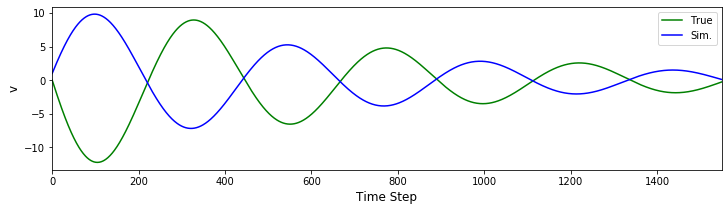

In [3]:
                                                     # settings
nt_asm = 400
nt_prd = 1000
obs_interval = 100
dastart = 150

nens = 10
initial_noise = 3.0

iter_max = 15

dt = 0.01
k = 2
mass = 1.0
dump = 0.3

#Observation noise
noise = 0.3 #standard deviation

#Initial condition
xt = 10.0; vt = 0.0 #True
xsf = -8.0; vsf = 1.0 #Simulation
                                     # make truth (and obs) and noDA run
#For Visuallization
#先把xt, vt等值放到xtrue, vtrue等vector裡，等等再用xture.append把積分後的值加在後面
xtrue = [xt];  vtrue = [vt] #True for visualization
xobs = [xt];   vobs = [vt] #Observation for visualization
xsim = [xsf];  vsim = [vsf] #Simulation for visualization
xs = xsf; vs = vsf
Pf = []

for t in range(dastart + nt_asm + nt_prd):
    #True,Observation and Simulation
    osc = Oscillation.Oscillation(xt,vt,noise,Pf, dt,k,mass,dump)  #call oscillation function as osc
    xt, vt = osc.time_integration()
    xo, vo = osc.observation_noise()
    
    #Simulation
    osc = Oscillation.Oscillation(xs,vs,noise,Pf, dt,k,mass,dump)
    xs, vs = osc.time_integration()
        
    #visualization
    xtrue.append(xt);  vtrue.append(vt)
    xobs.append(xo);   vobs.append(vo)
    xsim.append(xs);   vsim.append(vs)
    
vis = Visualization.Visualization(None, vtrue, vsim, [],obs_interval, nt_asm, 'v', dastart+nt_asm+nt_prd)
vis.fit()

In [4]:
                                          # produce an ensemble forecast
#xen = [xs];ven = [vs] 
xvsim = np.array([xsf, vsf])

#initial ensemble generation
#nens = 5
#initial_noise = 3.0
generate =  GenerateEnsemble.GenerateEnsemble(xvsim, nens, initial_noise)                                      
ensemble = generate.fit()

xen=ensemble[:,0];  ven=ensemble[:,1]
#print("initial X=",xen)

for t in range(dastart+1):
    #Data Assimilation
    for ens in range(nens):  # for each ensemble members
        osc = Oscillation.Oscillation(ensemble[ens,0],ensemble[ens,1],noise,None, dt,k,mass,dump)
        ensemble[ens,0],ensemble[ens,1] = osc.time_integration()    
        
    for i in range(ensemble.shape[1]):        
        if (i==0):
            xen=np.vstack((xen,ensemble[:,i]))
        elif (i==1):
            ven=np.vstack((ven,ensemble[:,i]))  

In [5]:
                                    # calcultae covariance from the ensemble
#Average
EnsembleAverage = []
for i in range(ensemble.shape[1]):
    EnsembleAverage.append(ensemble[:,i].mean())
print("ensemble mean at step",t,"is",EnsembleAverage)

#Perturb
for i in range(ensemble.shape[1]):   #for each model state
    Prtb = []
    for ens in range(ensemble.shape[0]):   # for each member
        Prtb.append(ensemble[ens,i]-EnsembleAverage[i])        
    if (i==0):
        EnsemblePrtb = Prtb
    else:
        EnsemblePrtb = np.vstack((EnsemblePrtb,Prtb))

#covariance
covariance = np.dot(EnsemblePrtb/(ensemble.shape[0]-1),EnsemblePrtb.T)
print(covariance,'covariance from ensemble')

ensemble mean at step 150 is [4.3881732434179215, 7.562981838755445]
[[ 2.62560892 -1.11551416]
 [-1.11551416 14.48580577]] covariance from ensemble


In [6]:
                                            # mean forecast
    
xs = EnsembleAverage[0]; vs = EnsembleAverage[1];
xmeanfcst = [xs];  vmeanfcst = [vs]

for t in range(nt_asm + nt_prd-1):
    #Data Assimilation
    osc = Oscillation.Oscillation(xs,vs,noise,Pf, dt,k,mass,dump)
    xs, vs = osc.time_integration()

    xmeanfcst.append(xs)
    vmeanfcst.append(vs)    

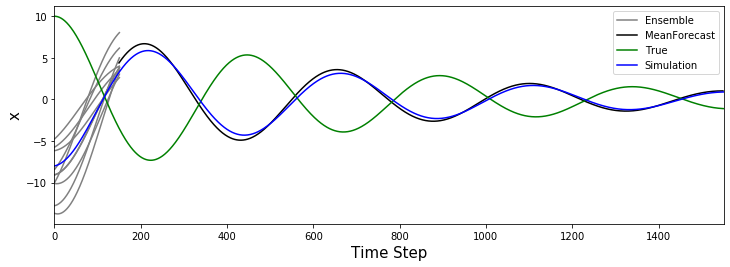

In [7]:
                                        # plot figure of noDA runs with x
_xrange = range(xen.shape[0])
_xrang0 = range(len(xtrue))
_xrang1 = range(dastart, len(xtrue)-1)
xlim = len(xtrue)
fig = plt.figure(figsize=(12, 4)) # figureオブジェクト作成
for ens in range(nens):
    if (ens==0):
        plt.plot(_xrange,xen[:,ens],color='grey',label='Ensemble')
    else:
        plt.plot(_xrange,xen[:,ens],color='grey')
plt.plot(_xrang1,xmeanfcst,color='black',label='MeanForecast')
plt.plot(_xrang0,xtrue,color='green',label='True')
plt.plot(_xrang0,xsim,color='blue',label='Simulation')
    #
plt.xlabel("Time Step",size=15)
plt.ylabel("x",size=15)
plt.xlim(0,xlim)
plt.legend()
#plt.savefig('showens_x_en40.png', dpi=100)
plt.show()

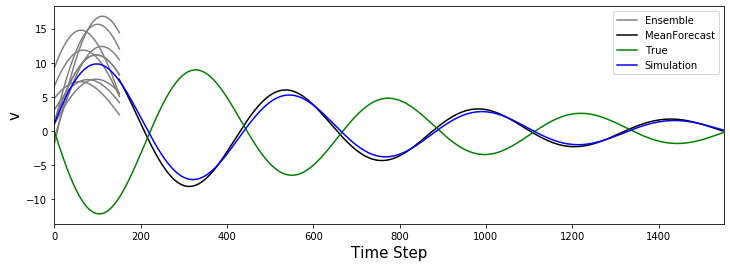

In [8]:
                                        # plot figure of noDA runs with v
fig = plt.figure(figsize=(12, 4))
for ens in range(nens):
    if (ens==0):
        plt.plot(_xrange,ven[:,ens],color='grey',label='Ensemble')
    else:
        plt.plot(_xrange,ven[:,ens],color='grey')
plt.plot(_xrang1,vmeanfcst,color='black',label='MeanForecast')
plt.plot(_xrang0,vtrue,color='green',label='True')
plt.plot(_xrang0,vsim,color='blue',label='Simulation')
    #
plt.xlabel("Time Step",size=15)
plt.ylabel("v",size=15)
plt.xlim(0,xlim)
plt.legend()
#plt.savefig('showens_v_en40.png', dpi=100)
plt.show()    

In [9]:
                                              # perform 4DVAR
#time step
#obs_interval = 100

#initial condition
#iter_max = 10
x_b = EnsembleAverage[0]; v_b = EnsembleAverage[1]

#---use covariance from ensemble---
B = covariance
#----------------------------------

#---simple 4DVAR-------------------
#B = np.array([[1, 0], [0, 1]])   #background error covariance
#----------------------------------

#observation
#H = np.array([1,0]).reshape(1,2)  # Observation only in x
#H = np.array([0,1]).reshape(1,2)   # Observation only in v
H = np.array([[1,0],[0,1]])       # Observation in x and v

xs = EnsembleAverage[0]; vs = EnsembleAverage[1]; #simulation
xobs_p=[]; vobs_p=[];  _obs=[] #obs points for plot
for iter in range(iter_max):
    J = 0.0
    adx = 0.0; adv = 0.0
    adx_tmp = 0.0; adv_tmp = 0.0
    
    xda = [xs]; vda = [vs] #Data Assimilation for visualization

    #simulation
    for t in range(nt_asm):
        #Data Assimilation        
        osc = Oscillation.Oscillation(xs,vs,noise,Pf, dt,k,mass,dump)
        xs, vs = osc.time_integration()
        xda.append(xs)
        vda.append(vs)

        # Cost Function
        if(np.mod(t,obs_interval) == 0 ):
            J = cost(J, H, xs, vs, xobs[t+dastart], vobs[t+dastart])
            #print("J=",J)
            if (iter==0):
                _obs.append(t)
                xobs_p.append(xobs[t+dastart])
                vobs_p.append(vobs[t+dastart])
               # print("t=",t,"obs:", xobs[t+dastart], vobs[t+dastart])

    # Adjoint model
    for t in range(nt_asm-1,-1,-1):
        if(np.mod(t,obs_interval) == 0 ):
            xtmp = adx_tmp + (xda[t] - xobs[t+dastart]) / noise
            vtmp = adv_tmp + (vda[t] - vobs[t+dastart]) / noise
        else:
            xtmp = 0.0
            vtmp = 0.0
        adx = adx_tmp - k * dt / mass * adv_tmp + xtmp
        adv = dt * adx_tmp + (1.0 - dump * dt / mass) * adv_tmp + vtmp

        adx_tmp = adx
        adv_tmp = adv
        
    # Background 
    invB = np.linalg.inv(B)  
    #----"full" En4DVAR----
    #J = J + 0.5 * (xda[0] - x_b)**2 / B[0,0] + 0.5 * (vda[0] - v_b)**2 / B[1,1]
    adx = adx + (xda[0] - x_b)* invB[0,0] + (vda[0] - v_b)* invB[1,0] 
    adv = adv + (vda[0] - v_b)* invB[1,1] + (xda[0] - x_b)* invB[0,1]
    #----------------------
    
    #----simple En4DVAR----
    #J = J + 0.5 * (xda[0] - x_b)**2 / B[0,0] + 0.5 * (vda[0] - v_b)**2 / B[1,1]
    #adx = adx + (xda[0] - x_b)/ B[0,0]
    #adv = adv + (vda[0] - v_b)/ B[1,1]
    #----------------------

    # Update x and v
    xs = xda[0] - 0.01 * adx
    vs = vda[0] - 0.01 * adv

xda = [xs];  vda = [vs] #Data Assimilation for visualization
#print(xda)

#Prediction
for t in range(nt_asm + nt_prd-1):
    #Data Assimilation
    osc = Oscillation.Oscillation(xs,vs,noise,Pf, dt,k,mass,dump)
    xs, vs = osc.time_integration()

    xda.append(xs)
    vda.append(vs)
    
#print(_obs,xobs_p)

RMSE of DA run = 0.21524979661869173


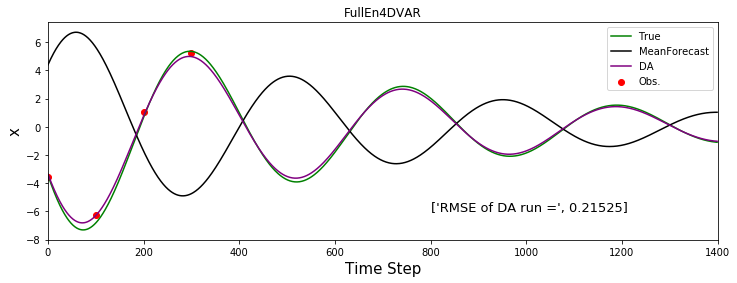

In [15]:
                                   # calculate RMSE and plot the figure for x
rmse=0.0
for i in range(len(xda)):
    rmse = rmse + (xtrue[i+dastart] - xda[i])**2
rmse = np.sqrt(rmse/len(xda))
print("RMSE of DA run =",rmse)
#
_xrange = range(len(xmeanfcst))
xlim=len(xmeanfcst)
fig = plt.figure(figsize=(12, 4)) # figureオブジェクト作成
#plt.plot(_xrange,xmeanfcst,color='black',label='MeanForecast')
plt.plot(_xrange,xtrue[dastart:dastart + nt_asm + nt_prd],color='green',label='True')
plt.plot(_xrange,xmeanfcst,color='black',label='MeanForecast')
#plt.plot(_xrange,xsim[dastart:dastart + nt_asm + nt_prd],color='blue',label='Simulation')
plt.plot(_xrange,xda,color='purple',label='DA')
plt.scatter(_obs,xobs_p,color='red',label='Obs.')
plt.text(800,-6,['RMSE of DA run =',round(rmse,5)], fontsize=13)
#
plt.xlabel("Time Step",size=15)
plt.ylabel("x",size=15)
plt.xlim(0,xlim)
plt.legend()
plt.title('FullEn4DVAR')
#plt.savefig('FullEn4DVAR_x_200.png', dpi=100)
plt.show()  
#

RMSE of DA run = 0.2971359030176056


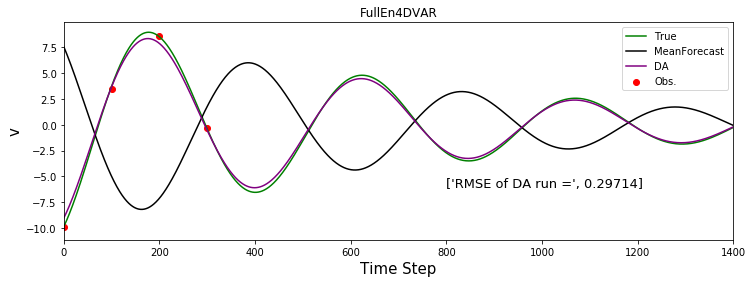

In [16]:
                                    #calculate RMSE and plot the figure for v
rmse=0.0
for i in range(len(vda)):
    rmse = rmse + (vtrue[i+dastart] - vda[i])**2
rmse = np.sqrt(rmse/len(vda))
print("RMSE of DA run =",rmse)
#
fig = plt.figure(figsize=(12, 4))
#plt.plot(_xrange,vmeanfcst,color='black',label='MeanForecast')
plt.plot(_xrange,vtrue[dastart:dastart + nt_asm + nt_prd],color='green',label='True')
plt.plot(_xrange,vmeanfcst,color='black',label='MeanForecast')
#plt.plot(_xrange,vsim[dastart:dastart + nt_asm + nt_prd],color='blue',label='Simulation')
plt.plot(_xrange,vda,color='purple',label='DA')
plt.scatter(_obs,vobs_p,color='red',label='Obs.')
plt.text(800,-6,['RMSE of DA run =',round(rmse,5)], fontsize=13)
#
plt.xlabel("Time Step",size=15)
plt.ylabel("v",size=15)
plt.xlim(0,xlim)
plt.legend()
plt.title('FullEn4DVAR')
#plt.savefig('FullEn4DVAR_v_200', dpi=100)
plt.show()  
#